Paper:
https://arxiv.org/pdf/1512.04150.pdf

GitHub:
https://github.com/jacobgil/keras-cam

In [1]:
import glob
import os, sys
import numpy as np
import scipy

import cv2
import skimage
import matplotlib.pyplot as plt
from keras.preprocessing import image as kimage

plt.style.use('ggplot')
%matplotlib inline
sys.path.insert(0,'..') # add parent directory to path

import keras
from keras.utils.np_utils import to_categorical
import h5py

from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras import backend as K
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

from keras.models import *
from keras.callbacks import *
import keras.backend as K

from sklearn.model_selection import train_test_split

import utils
import core_models
import poet_file_manager

from tqdm import tqdm

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [5]:
img_width = 224
img_size = (img_width, img_width)
img_shape = (img_width, img_width, 3)

In [6]:
train_ids, test_ids = utils.load_object('../train_ids.pkl'), utils.load_object('../test_ids.pkl')

In [7]:
def global_average_pooling(x):
    return K.mean(x, axis = (1, 2))

def global_average_pooling_shape(input_shape):
    return input_shape[2:4]

def get_model(out_classes, img_shape, mode='vgg'):
    
    if mode=='vgg':
        model = core_models.VGG16_convolutions(img_shape=img_shape)
        model = load_model_weights(model, "./vgg.h5")

    #     model = resnet()
        for layer in model.layers[:]:
            layer.trainable = False
    
    if mode=='other':
        model = core_models.other_model(img_shape)
        
    # Rename last conv layer to later access it for CAM
    model.layers[-1].name = 'last_conv'
    
    # There cannot be any other layer in between the Dense and Global Average Pooling
    # due to how class activations are generated
    model.add(Lambda(global_average_pooling, 
              output_shape=global_average_pooling_shape))
    model.add(Dense(out_classes, activation = 'softmax'))

    optm = Adam()
    model.compile(loss = 'categorical_crossentropy', optimizer = optm, metrics=['accuracy'])
    
    print(model.summary())
    for layer in model.layers:
        print(layer.name, layer.trainable)
    return model

def load_model_weights(model, weights_path):
    print('Loading model.')

    model.load_weights(weights_path)

    return model

def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

In [5]:
def print_proba_results(proba_res, inv_class_map):
    for i, proba in enumerate(proba_res):
        print(inv_class_map[proba[0]], proba[1])

def visualize_class_activation_map(model, original_img, output_path, class_map, 
                                   visualize_for_class=None, cam_thresh=0.4):
    # adapted from https://github.com/jacobgil/keras-cam
    # visualize_for_class_n decides for which class the CAM should be plotted
    inv_class_map = {value: key for key, value in class_map.items()}
    
#     model = load_model(model_path)
    width, height, _ = original_img.shape

    img = np.array([np.float32(original_img)])

    class_weights = model.layers[-1].get_weights()[0]
    final_conv_layer = get_output_layer(model, "last_conv")
    
    get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
    
    proba_res = [(i, proba) for i, proba in enumerate(predictions[0])]
    proba_res.sort(key= lambda pair: pair[1], reverse=True)
#     print(proba_res)
    for i, proba in enumerate(proba_res):
        print(inv_class_map[proba[0]], proba[1])
        if i == 1:
            second_class_n = proba[0]
    
    conv_outputs = conv_outputs[0, :, :, :]
#     print('class weights:', class_weights.shape)
    
    if visualize_for_class == 'second':
        visualize_for_class = second_class_n
    elif type(visualize_for_class) == str:
        visualize_for_class = class_map[visualize_for_class]
    
    # visualize the maximum prob class if no class was specified in arguments
    if visualize_for_class is None:
        class_n = np.argmax(predictions)
    else:
        class_n = visualize_for_class
        
    print("Visualizing for", inv_class_map[class_n])
    print("Prediction", inv_class_map[np.argmax(predictions)])

    #Create the class activation map.
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_n]):
        cam += w * conv_outputs[:, :, i]
    
#     cam /= np.max(cam)
    cam = cv2.resize(cam, (height, width))
#     cam = utils.normalize(cam)
    
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    if cam_thresh is not None:
        heatmap[np.where(cam < cam_thresh)] = 0
    
    img = (heatmap*0.5 + original_img)
    img /= np.max(img)
    
    plt.imshow(img)
    plt.grid(False)
#     plt.show()
    return cam, proba_res
#     cv2.imwrite(output_path, img)
#     cv2.imshow('test', img)

In [6]:
train_0 = [el.split('/')[-1] for el in glob.glob('./train/0/*')]
test_0 = [el.split('/')[-1] for el in glob.glob('./test/0/*')]

In [7]:
len(train_0), len(test_0)

(599, 67)

In [8]:
np.sum([el in train_0 for el in test_0]) # check that test and train are disjoint

0

In [9]:
epochs_n = 200
batch_size = 32

if not os.path.exists('./weights'):
    os.makedirs('./weights')
checkpoint_path="./weights/vggweights.{epoch:02d}-{val_loss:.2f}.hdf5"

train_data_dir = './train/'
test_data_dir = './test/'

train_datagen = ImageDataGenerator(
                                   horizontal_flip=False
                                )

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

X_test, y_test, class_map, names = poet_file_manager.load_poet(img_size, test_ids)

Found 5517 images belonging to 10 classes.
Loading POET dataset...
aeroplane* 0
boat* 1
dog* 2
bicycle* 3
cat* 4
cow* 5
diningtable* 6
horse* 7
motorbike* 8
sofa* 9
X.shape: (614, 224, 224, 3) y.shape: (614,)
Loaded POET dataset.


In [10]:
class_map

{'aeroplane': 0,
 'boat': 1,
 'dog': 2,
 'bicycle': 3,
 'cat': 4,
 'cow': 5,
 'diningtable': 6,
 'horse': 7,
 'motorbike': 8,
 'sofa': 9}

In [62]:
model = get_model(out_classes=10, img_shape=img_shape, mode='vgg')

/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/cam/core_models.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1")`
  model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/cam/core_models.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_2")`
  model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/cam/core_models.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_1")`
  model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
/home/mikey/Repos/visual-attention-cnn-and-eye-tracking/cam/core_models.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_2")`
  mod

Loading model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_92 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_93 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_94 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856 

In [63]:
print("Training..")
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
earlystopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.005, mode='min', verbose=10, restore_best_weights=True)

history = model.fit_generator(train_generator, epochs=epochs_n, callbacks=[checkpoint, earlystopping], validation_data=(X_test, y_test),
                             steps_per_epoch = len(train_generator.filenames) // batch_size)

Training..
Epoch 1/200
172/172 [==============================] - 27s 156ms/step - loss: 2.3582 - acc: 0.4881 - val_loss: 1.3047 - val_acc: 0.6466
Epoch 2/200
172/172 [==============================] - 26s 153ms/step - loss: 0.9848 - acc: 0.7128 - val_loss: 0.9884 - val_acc: 0.7117
Epoch 3/200
172/172 [==============================] - 26s 153ms/step - loss: 0.7504 - acc: 0.7699 - val_loss: 0.8612 - val_acc: 0.7427
Epoch 4/200
172/172 [==============================] - 26s 154ms/step - loss: 0.6201 - acc: 0.8022 - val_loss: 0.7756 - val_acc: 0.7459
Epoch 5/200
172/172 [==============================] - 26s 154ms/step - loss: 0.5330 - acc: 0.8305 - val_loss: 0.7551 - val_acc: 0.7622
Epoch 6/200
172/172 [==============================] - 26s 153ms/step - loss: 0.4702 - acc: 0.8442 - val_loss: 0.7229 - val_acc: 0.7818
Epoch 7/200
172/172 [==============================] - 26s 154ms/step - loss: 0.4257 - acc: 0.8578 - val_loss: 0.7126 - val_acc: 0.7752
Epoch 8/200
172/172 [================

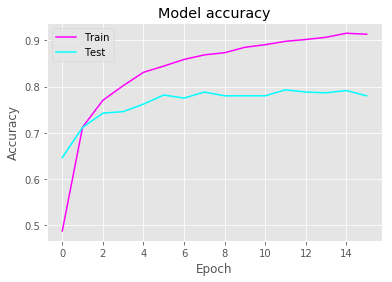

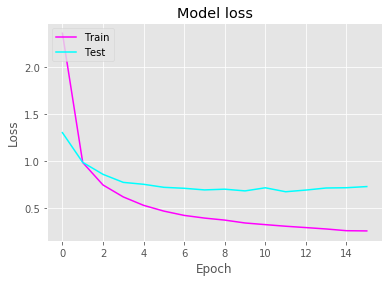

In [65]:
utils.plot_history(history)

In [159]:
inv_class_map = inv_map = {v: k for k, v in class_map.items()}
model_path = './weights/vggweights.12-0.68.hdf5'

In [160]:
model = load_model(model_path)
y_pred = model.predict(X_test)

In [161]:
np.mean(np.argmax(y_test, 1) == np.argmax(y_pred, 1))

0.7931596091205212

Normalized confusion matrix


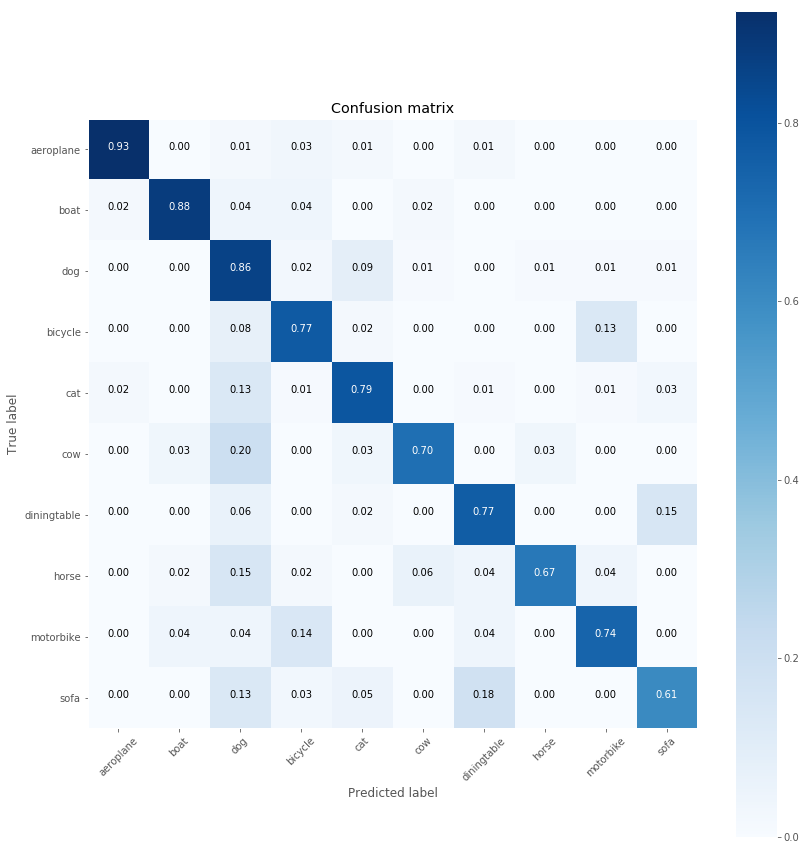

In [162]:
plt.figure(figsize=(12,12))
fig = utils.plot_confusion_matrix(np.argmax(y_test, 1), np.argmax(y_pred, 1), class_map.keys(), normalize=True)

In [163]:
mistakes_mask = np.argmax(y_test, 1) != np.argmax(y_pred, 1)
print(np.mean(np.logical_not(mistakes_mask)))
mistakes_names = names[mistakes_mask]
correct_names = names[np.logical_not(mistakes_mask)]
print(len(mistakes_names))

0.7931596091205212
127


In [164]:
np.argmax(y_test, 1)[mistakes_mask], np.argmax(y_pred, 1)[mistakes_mask]

(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]),
 array([6, 2, 4, 3, 3, 3, 2, 2, 5, 0, 3, 4, 4, 8, 4, 4, 3, 4, 3, 4, 4, 3,
        4, 9, 7, 4, 4, 5, 4, 8, 8, 8, 8, 8, 2, 8, 2, 2, 4, 2, 8, 2, 0, 3,
        2, 2, 2, 9, 0, 2, 2, 2, 2, 2, 2, 8, 2, 2, 9, 6, 2, 9, 2, 2, 2, 2,
        7, 2, 2, 1, 2, 4, 2, 9, 9, 9, 4, 2, 9, 9, 2, 9, 9, 6, 2, 2, 5, 3,
        8, 5, 5, 2, 2, 2, 8, 2, 6, 1, 2, 3, 3, 2, 1, 1, 6, 2, 3, 6, 3, 3,
        3, 3, 3, 6, 2, 6, 4, 2, 2, 2, 4, 6, 6, 6, 6, 2, 6]))

In [165]:
# name = 'dog_2010_005149.jpg'
mistake_n = 5
name = mistakes_names[mistake_n]
print(name)
print(inv_class_map[np.argmax(y_pred, 1)[mistakes_mask][mistake_n]])
print(y_pred[mistakes_mask][mistake_n])
# image = X_test[mistakes_mask][mistake_n]

boat_2009_004786.jpg
bicycle
[2.2799679e-04 2.4541724e-01 1.9560216e-02 5.0273401e-01 6.2150028e-02
 1.0457919e-04 1.0824766e-06 3.0049073e-06 1.6980134e-01 5.1747793e-07]


In [166]:
def get_class(images, cat_labels, class_name):
    class_mask = np.argmax(cat_labels, 1) == class_map[class_name]
    return images[class_mask]

def get_image(images, file_names, image_name):
    index = list(file_names).index(image_name)
    return images[index]

get_image(X_test, names, name).shape, image.shape

((224, 224, 3), (224, 224, 3))

bicycle 0.50273275
boat 0.24541737
motorbike 0.16980247
cat 0.06215019
dog 0.019560043
aeroplane 0.00022799558
cow 0.00010458073
horse 3.0049341e-06
diningtable 1.0824924e-06
sofa 5.174732e-07
Visualizing for boat
Prediction bicycle
bicycle 0.50273275
boat 0.24541737
motorbike 0.16980247
cat 0.06215019
dog 0.019560043
aeroplane 0.00022799558
cow 0.00010458073
horse 3.0049341e-06
diningtable 1.0824924e-06
sofa 5.174732e-07
Visualizing for bicycle
Prediction bicycle


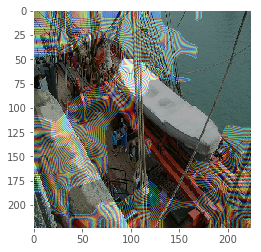

In [167]:
heatmap, org_img = visualize_class_activation_map(model=model, 
                                   original_img=get_image(X_test, names, name), 
                                   output_path='poet0.jpg', class_map=class_map, cam_thresh=0.6,
                                    visualize_for_class=name.split('_')[0])

heatmap, org_img = visualize_class_activation_map(model=model, 
                                   original_img=get_image(X_test, names, name), 
                                   output_path='poet0.jpg', class_map=class_map, cam_thresh=0.6,
                                    visualize_for_class=None)

In [168]:
org_img.shape

(224, 224, 3)

cow 0.90934
dog 0.08677049
cat 0.0038459362
horse 4.1650324e-05
diningtable 6.065648e-07
bicycle 4.1156056e-07
motorbike 3.376699e-07
boat 2.0023036e-07
aeroplane 1.4402424e-07
sofa 6.567445e-08
Visualizing for cow
Prediction cow


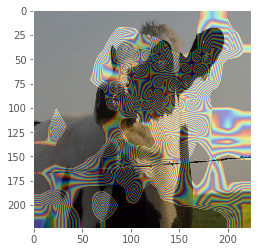

In [169]:
heatmap, org_img = visualize_class_activation_map(model=model, 
                                   original_img=get_class(X_test, y_test, 'cow')[10], 
                                   output_path='poet0.jpg', class_map=class_map, cam_thresh=0.1)

In [170]:
# name = 'dog_2010_005149.jpg'

print(name)
print(inv_class_map[np.argmax(y_pred, 1)[mistakes_mask][mistake_n]])
print(y_pred[mistakes_mask][mistake_n])
# image = X_test[mistakes_mask][mistake_n]

boat_2009_004786.jpg
bicycle
[2.2799679e-04 2.4541724e-01 1.9560216e-02 5.0273401e-01 6.2150028e-02
 1.0457919e-04 1.0824766e-06 3.0049073e-06 1.6980134e-01 5.1747793e-07]


In [172]:
human_heatmaps = np.load('./heatmaps_resized.npy').tolist()

In [173]:
human_heatmaps_values = list(human_heatmaps.values())
len(human_heatmaps_values)

614

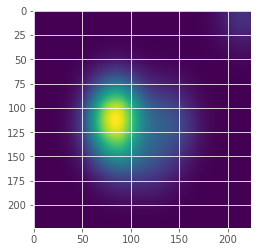

In [174]:
plt.imshow(human_heatmaps_values[0])

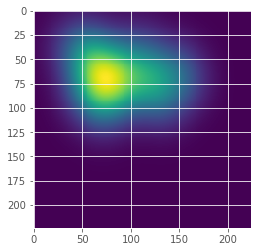

In [175]:
plt.imshow(human_heatmaps_values[10])

In [10]:
def pearson(a, b):
    return scipy.stats.pearsonr(a.reshape(-1,), b.reshape(-1,))[0]

def construct_name(class_name, file_id):
    return class_name + '_' + str(file_id) + '.jpg'

def overlay_heatmap(org_img, heatmap, gauss_sigma=None, thresh=None, normalize=False, absolute=False):
    img = org_img/255
    if absolute:
        heatmap = np.abs(heatmap)
    
    if thresh:
        heatmap[heatmap < thresh] = 0
    
    if normalize:
        heatmap = utils.normalize(heatmap)
        
#     print(np.min(heatmap), np.max(heatmap))
    if gauss_sigma is not None:
        heatmap = scipy.ndimage.filters.gaussian_filter(heatmap, sigma=gauss_sigma)
    
    if not normalize:
        heatmap = heatmap / 40
    
    heatmap_jet = plt.imshow(heatmap, cmap='jet')
    
    if normalize:
        pass
    else:
        if absolute:
            plt.clim(0,1)
        else:
            plt.clim(-1,1)
    
    colorbar = plt.colorbar()
#     print(colorbar)
#     plt.show()
    
    heatmap_jet.write_png('heatmap.png')
    heatmap_jet_ld = scipy.misc.imread('heatmap.png')
    heatmap_jet_ld = heatmap_jet_ld/ 255
    alpha = 0.5
    

    out_img = np.zeros(img.shape,dtype=img.dtype)
    out_img[:,:,0] = alpha*img[:,:,0] + (1-alpha)* heatmap_jet_ld[:,:,0]
    out_img[:,:,1] = alpha*img[:,:,1] + (1-alpha)* heatmap_jet_ld[:,:,1]
    out_img[:,:,2] = alpha*img[:,:,2] + (1-alpha)* heatmap_jet_ld[:,:,2]

    return out_img, colorbar

results = {}
def construct_res(image, ground_truth, first, second, correct, prob_res):
    def get_hm_dict(gt, hm):
        return{
            'hm': hm,
            'pcc': pearson(np.abs(hm), gt)
        }
    return {
        'image': image,
        'ground_truth': get_hm_dict(ground_truth, ground_truth),
        'first_prob': get_hm_dict(ground_truth, first),
        'second_prob': get_hm_dict(ground_truth, second),
        'correct': get_hm_dict(ground_truth, correct),
        'prob_res': prob_res
    }

for sample_n in tqdm(range(X_test.shape[0])):
    name = names[sample_n]
    # name = correct_names[sample_n]
    print(name)

    image = get_image(X_test, names, name)
    ground_truth_heatmap = human_heatmaps[name].copy()

#     plt.imshow(utils.normalize(image))
#     plt.grid(False)
#     plt.show()

    first, prob_res = visualize_class_activation_map(model=model, 
                                       original_img=image, 
                                       output_path='poet0.jpg', class_map=class_map, 
                                       visualize_for_class=None, cam_thresh=0.)
#     print("Pearson", pearson(np.abs(heatmap), ground_truth_heatmap))

#     img, colorbar = overlay_heatmap(org_img, heatmap, absolute=True)
#     plt.imshow(img, cmap='jet')
#     # plt.colorbar()
#     frame1 = plt.gca()
#     frame1.axes.xaxis.set_ticks([])
#     frame1.axes.yaxis.set_ticks([])
# #     plt.show()

    second, prob_res = visualize_class_activation_map(model=model, 
                                       original_img=image, 
                                       output_path='poet0.jpg', class_map=class_map, 
                                       visualize_for_class='second', cam_thresh=0.)
#     print("Pearson", pearson(np.abs(heatmap), ground_truth_heatmap))

#     img, colorbar = overlay_heatmap(org_img, heatmap, absolute=True)
#     plt.imshow(img, cmap='jet')
#     # plt.colorbar()
#     plt.show()

    correct, prob_res = visualize_class_activation_map(model=model, 
                                       original_img=image, 
                                       output_path='poet0.jpg', class_map=class_map, 
                                       visualize_for_class=name.split('_')[0], cam_thresh=0.)
#     print("Pearson", pearson(heatmap, ground_truth_heatmap))

#     img, colorbar = overlay_heatmap(org_img, heatmap, absolute=True)
#     plt.imshow(img, cmap='jet')
#     # plt.colorbar()
# #     plt.show()

#     plt.imshow(ground_truth_heatmap, cmap='jet')
#     # plt.colorbar()
# #     plt.show()

#     img, colorbar = overlay_heatmap(org_img, ground_truth_heatmap, thresh=None, normalize=True)
#     plt.imshow(img)
#     # plt.colorbar()
#     plt.grid(False)
#     plt.show()
    results[name] = construct_res(image, ground_truth_heatmap, first ,second ,correct, prob_res)

  0%|          | 0/614 [00:00<?, ?it/s]

aeroplane_2011_001962.jpg


NameError: name 'get_image' is not defined

In [11]:
hm_test = utils.load_object('cam_heatmaps_test.pkl')
class_map = utils.load_object('cam_classmap.pkl')

In [12]:
soft_test = utils.load_object('../soft_attention_model/soft_att_results.pkl')
soft_class_map = utils.load_object('../soft_attention_model/soft_classmap.pkl')

In [48]:
# soft_to_cam_class_n = {}
for soft_class_n in soft_class_map.keys():
    soft_class_name = soft_class_map[soft_class_n]
    cam_class_n = class_map[soft_class_name]
    print('Soft class number', soft_class_n)
    print('Cam class number', cam_class_n)
#     soft_to_cam_class_n[soft_class_n] = cam_class_n
    
# class_map, soft_class_map

Soft class number 0
Cam class number 2
Soft class number 1
Cam class number 0
Soft class number 2
Cam class number 1
Soft class number 3
Cam class number 3
Soft class number 4
Cam class number 4
Soft class number 5
Cam class number 5
Soft class number 6
Cam class number 6
Soft class number 7
Cam class number 7
Soft class number 8
Cam class number 8
Soft class number 9
Cam class number 9


In [49]:
cam_test = {key: value for key, value in hm_test.items() if key in list(soft_test.keys())}

In [50]:
soft_test['aeroplane_2011_001962.jpg'].keys()

dict_keys(['avg_heatmap', 'attention_vis', 'prob_res'])

In [42]:
for key in list(cam_test.keys())[:2]:
    soft_res = soft_test[key]
    cam_res = cam_test[key]
    
    for key, prob_list in soft_res['prob_res'].items():
        if key == 'c':
            print_proba_results(prob_list, soft_class_map)
#         for i, el in enumerate(prob_list):
#             prob_list[i] = (soft_to_cam_class_n[prob_list[i][0]], prob_list[i][1])
    print('')
            
    print_proba_results(cam_res['prob_res'], {value:key for key,value in class_map.items()})
    print('')

aeroplane 0.93813497
boat 0.045088813
motorbike 0.007334693
bicycle 0.005315444
horse 0.0016120482
dog 0.0011533909
diningtable 0.0005088223
sofa 0.00038883314
cow 0.0003601627
cat 0.00010289001

aeroplane 0.99983037
boat 0.00010107423
dog 1.9047477e-05
motorbike 1.7029686e-05
bicycle 1.4523885e-05
diningtable 1.4226935e-05
horse 3.435414e-06
cat 8.5918494e-08
sofa 7.751303e-08
cow 5.721757e-08

aeroplane 0.9689386
boat 0.02449622
motorbike 0.003612719
bicycle 0.0025897268
dog 0.00013130157
diningtable 8.361913e-05
sofa 7.358189e-05
horse 5.7785885e-05
cat 8.316506e-06
cow 8.196211e-06

aeroplane 0.99999976
cow 1.4562937e-07
boat 8.983129e-08
motorbike 1.6145502e-09
horse 2.2390541e-10
diningtable 4.0323522e-11
sofa 1.3366426e-11
dog 3.940384e-12
bicycle 2.6401407e-12
cat 1.4544328e-12



In [52]:
all_res = {}
all_map = class_map
all_inv_map = {value:key for key,value in class_map.items()}
for key in list(cam_test.keys())[:]:
    soft_res = soft_test[key]
    cam_res = cam_test[key]
    
    all_res[key] = {
        'soft_res': soft_res,
        'cam_res': cam_res
    }

In [53]:
utils.save_object(all_res, 'all_res.pkl')
utils.save_object(all_map, 'all_map.pkl')
utils.save_object(all_inv_map, 'all_inv_map.pkl')

In [262]:
a = hm_test[name]['ground_truth']['hm']

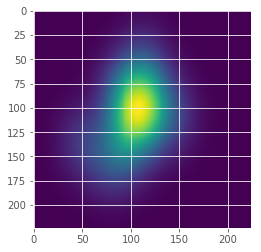

In [263]:
plt.imshow(a)

In [13]:
hm_test = utils.load_object('cam_heatmaps_test.pkl')
class_map = utils.load_object('cam_classmap.pkl')

In [14]:
string_to_int_classmap = class_map
int_to_string_classmap = {value: key for key, value in class_map.items()}

In [15]:
name = list(hm_test.keys())[1]

def translate_prob_res(prob_res):
    return [(int_to_string_classmap[el[0]], el[1]) for el in prob_res]



In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [9]:
col_names = ['id', 'true_class', 'cam_prediction', 'cam_certainty', 'cam_first_prob_pcc', 
             'cam_second_prob_pcc', 'cam_true_class_pcc', 'cam_all_probas']

df = pd.DataFrame(columns=col_names)

for name in list(hm_test.keys()):
    print(name)
    prob_res_string = translate_prob_res(hm_test[name]['prob_res'])
    row = [name, 
           name.split('_')[0],
           prob_res_string[0][0],
           prob_res_string[0][1],
           hm_test[name]['first_prob']['pcc'], 
           hm_test[name]['second_prob']['pcc'], 
           hm_test[name]['correct']['pcc'],
           prob_res_string
          ]
    df = df.append({key: value for key,value in zip(col_names, row)}, ignore_index=True)

NameError: name 'hm_test' is not defined

,id,true_class,cam_prediction,cam_certainty,cam_first_prob_pcc,cam_second_prob_pcc,cam_true_class_pcc,cam_all_probas
0,aeroplane_2011_001962.jpg,aeroplane,aeroplane,0.999830,0.380033,0.269075,0.380033,"[('aeroplane', 0.99983037), ('boat', 0.0001010..."
1,aeroplane_2008_006109.jpg,aeroplane,aeroplane,0.899827,0.749729,0.426962,0.749729,"[('aeroplane', 0.89982665), ('dog', 0.04147482..."
2,aeroplane_2011_002993.jpg,aeroplane,aeroplane,0.994208,0.593360,0.693959,0.593360,"[('aeroplane', 0.99420834), ('cat', 0.00237937..."
3,aeroplane_2009_002047.jpg,aeroplane,aeroplane,0.999975,0.190588,0.443428,0.190588,"[('aeroplane', 0.99997497), ('horse', 2.362287..."
4,aeroplane_2009_001372.jpg,aeroplane,aeroplane,0.999914,0.619541,0.293687,0.619541,"[('aeroplane', 0.99991405), ('cow', 6.595811e-..."


In [11]:
correct_mask = df['true_class'] == df['cam_prediction']
df[np.logical_not(correct_mask)].describe()

,cam_certainty,cam_first_prob_pcc,cam_second_prob_pcc,cam_true_class_pcc
count,127.000000,127.000000,127.000000,127.000000
mean,0.683670,0.264273,0.272408,0.258335
std,0.198040,0.245723,0.231537,0.237876
min,0.326530,-0.231843,-0.235843,-0.235843
25%,0.520995,0.061824,0.116955,0.075757
50%,0.678335,0.280722,0.240341,0.240341
75%,0.853759,0.437270,0.442394,0.438971
max,0.998715,0.893253,0.808285,0.808285


In [12]:
df[correct_mask].describe()

,cam_certainty,cam_first_prob_pcc,cam_second_prob_pcc,cam_true_class_pcc
count,487.000000,487.000000,487.000000,487.000000
mean,0.921525,0.448085,0.342861,0.448085
std,0.144899,0.272139,0.232098,0.272139
min,0.252612,-0.378363,-0.268641,-0.378363
25%,0.911478,0.236648,0.167978,0.236648
50%,0.995162,0.471221,0.351190,0.471221
75%,0.999950,0.666936,0.511276,0.666936
max,1.000000,0.943662,0.877318,0.943662


Text(0, 0.5, 'Count')

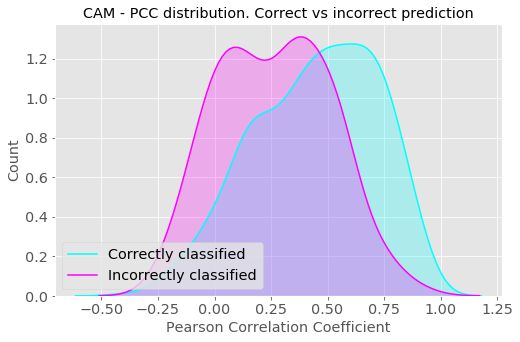

In [37]:
import seaborn as sns

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

c1,c2 = 'magenta', 'cyan'
fig = sns.kdeplot(df[correct_mask]['cam_first_prob_pcc'], shade=True, color=c2, label='Correctly classified')
fig = sns.kdeplot(df[np.logical_not(correct_mask)]['cam_first_prob_pcc'], shade=True, color=c1, label='Incorrectly classified')
plt.legend(loc=3)
plt.title("CAM - PCC distribution. Correct vs incorrect prediction")
plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

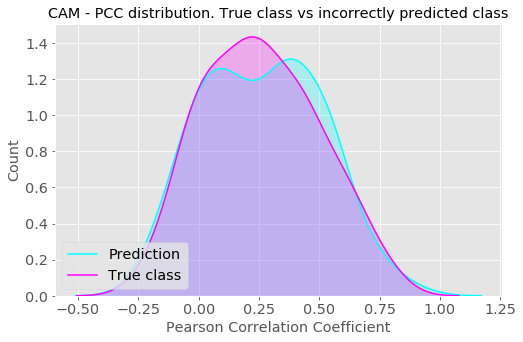

In [36]:
c1,c2 = 'magenta', 'cyan'
fig = sns.kdeplot(df[np.logical_not(correct_mask)]['cam_first_prob_pcc'], shade=True, color=c2, label='Prediction')
fig = sns.kdeplot(df[np.logical_not(correct_mask)]['cam_true_class_pcc'], shade=True, color=c1, label='True class')
plt.legend(loc=3)
plt.title("CAM - PCC distribution. True class vs incorrectly predicted class")
plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel("Count")

Text(0, 0.5, 'Highest prediction probability')

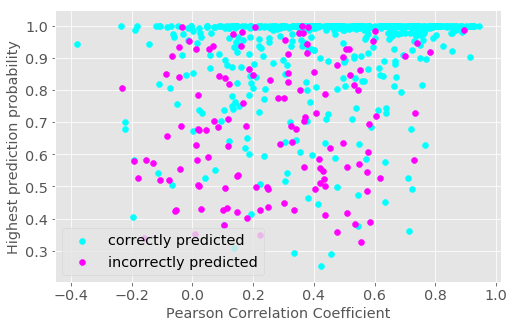

In [38]:
plt.scatter(df[correct_mask]['cam_first_prob_pcc'], df[correct_mask]['cam_certainty'], c='cyan', label='correctly predicted')
plt.scatter(df[np.logical_not(correct_mask)]['cam_first_prob_pcc'], df[np.logical_not(correct_mask)]['cam_certainty'], c='magenta', label='incorrectly predicted')
plt.legend()
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Highest prediction probability')

In [40]:
def pearson(a, b):
    return scipy.stats.pearsonr(a, b)[0]

pearson(df[correct_mask]['cam_first_prob_pcc'], df[correct_mask]['cam_certainty']), pearson(df[np.logical_not(correct_mask)]['cam_first_prob_pcc'], df[np.logical_not(correct_mask)]['cam_certainty'])

(0.2241545483379863, 0.130739635137539)

In [41]:
pearson(df['cam_first_prob_pcc'], df['cam_certainty'])

0.30354630661801424

In [ ]:
import seaborn as sns

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

c1,c2 = 'magenta', 'cyan'
fig = sns.kdeplot(df[correct_mask]['soft_att'], shade=True, color=c2, label='Correctly classified')
fig = sns.kdeplot(df[np.logical_not(correct_mask)]['cam_first_prob_pcc'], shade=True, color=c1, label='Incorrectly classified')
plt.title("Distribution of the pearson correlation coefficient for CAM")
plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel("Count")

(array([ 1.,  0.,  0.,  0.,  0.,  3.,  1.,  3.,  1.,  2.,  3.,  5.,  4.,
         4.,  7.,  6.,  6.,  7., 11., 20.,  7., 17., 11.,  9.,  9., 16.,
        11., 12., 15., 20.,  8., 20., 19., 11., 22., 17., 13., 14., 20.,
        21., 10., 21., 16., 15., 11., 10., 10.,  8.,  4.,  6.]),
 array([-0.37836279, -0.35192229, -0.32548179, -0.29904129, -0.27260079,
        -0.24616029, -0.21971979, -0.19327929, -0.16683879, -0.14039829,
        -0.11395779, -0.08751729, -0.06107679, -0.03463629, -0.00819579,
         0.01824471,  0.04468521,  0.07112571,  0.09756621,  0.12400671,
         0.15044721,  0.17688771,  0.20332821,  0.22976871,  0.25620921,
         0.28264971,  0.30909021,  0.33553071,  0.36197121,  0.38841171,
         0.41485221,  0.44129271,  0.46773321,  0.49417371,  0.52061421,
         0.54705471,  0.57349521,  0.59993571,  0.6263762 ,  0.6528167 ,
         0.6792572 ,  0.7056977 ,  0.7321382 ,  0.7585787 ,  0.7850192 ,
         0.8114597 ,  0.8379002 ,  0.8643407 ,  0.8907812 ,

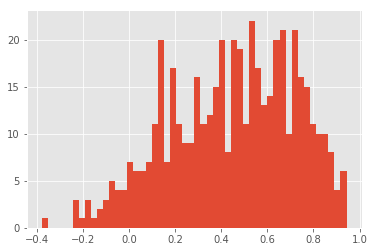

In [21]:
plt.hist(df[correct_mask]['cam_first_prob_pcc'], bins=50)

(array([1., 1., 1., 2., 1., 1., 3., 3., 5., 1., 3., 7., 3., 2., 4., 6., 4.,
        3., 3., 3., 2., 4., 1., 4., 5., 3., 6., 3., 6., 5., 1., 2., 5., 3.,
        5., 3., 3., 3., 0., 0., 0., 1., 2., 1., 0., 1., 0., 0., 0., 1.]),
 array([-0.23184287, -0.20934095, -0.18683903, -0.1643371 , -0.14183518,
        -0.11933325, -0.09683133, -0.0743294 , -0.05182748, -0.02932555,
        -0.00682363,  0.0156783 ,  0.03818022,  0.06068214,  0.08318407,
         0.10568599,  0.12818792,  0.15068984,  0.17319177,  0.19569369,
         0.21819562,  0.24069754,  0.26319946,  0.28570139,  0.30820331,
         0.33070524,  0.35320716,  0.37570909,  0.39821101,  0.42071294,
         0.44321486,  0.46571678,  0.48821871,  0.51072063,  0.53322256,
         0.55572448,  0.57822641,  0.60072833,  0.62323026,  0.64573218,
         0.66823411,  0.69073603,  0.71323795,  0.73573988,  0.7582418 ,
         0.78074373,  0.80324565,  0.82574758,  0.8482495 ,  0.87075143,
         0.89325335]),
 <a list of 50 Patch 

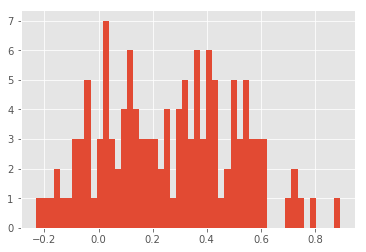

In [22]:
plt.hist(df[np.logical_not(correct_mask)]['cam_first_prob_pcc'], bins=50)

Prediction results:
dog 0.4911367
cat 0.48945406
horse 0.0102490485
cow 0.0055787335
diningtable 0.002370238
sofa 0.0011656438
boat 3.32352e-05
motorbike 8.000034e-06
aeroplane 2.744337e-06
bicycle 1.5319147e-06


/home/mikey/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


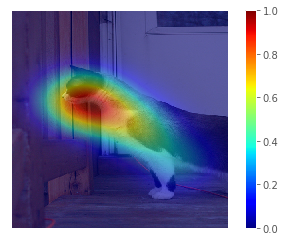

Perason correlation with ground truth: 1.0


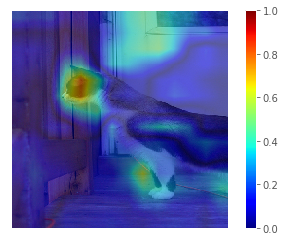

Prediction: dog
Perason correlation with ground truth: 0.25002479808230943


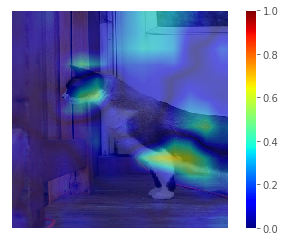

Prediction: cat
Perason correlation with ground truth: 0.1297767476769026


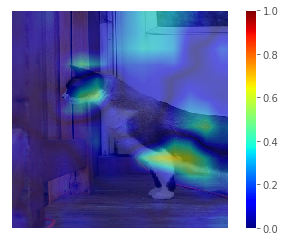

Prediction: cat
Perason correlation with ground truth: 0.1297767476769026


In [36]:
name = list(hm_test.keys())[350]

keys_to_vis = ['ground_truth', 'first_prob', 'second_prob', 'correct']

def visualize(name, heatmap_results_list, class_map):    
    inv_class_map = {value: key for key, value in class_map.items()}
    hm_results = heatmap_results_list[name]
    print("Prediction results:")
    print_proba_results(hm_results['prob_res'], inv_class_map)
    
    for key in keys_to_vis:
        hm_result = hm_results[key]
        img, colorbar = overlay_heatmap(hm_results['image'], hm_result['hm'], 
                                        normalize=(key == 'ground_truth'), absolute=True)
        plt.imshow(img, cmap='jet')
        # plt.colorbar()
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticks([])
        frame1.axes.yaxis.set_ticks([])
        plt.show()
        if key == 'first_prob':
            print("Prediction:", inv_class_map[hm_results['prob_res'][0][0]])
        elif key == 'second_prob':
            print("Prediction:", inv_class_map[hm_results['prob_res'][1][0]])
        elif key == 'correct':
            for res in hm_results['prob_res']:
                class_n, prob = res
                if inv_class_map[class_n] == name.split('_')[0]:
                    print("Prediction:", inv_class_map[class_n])
        
        print("Perason correlation with ground truth:", hm_result['pcc'])
    
visualize(name, hm_test, class_map)

## org_img.shape

In [30]:
def screen_area(deg):
    return 0.6 * np.tan(np.deg2rad(deg))

def pixels(deg):
    return screen_area(deg) / (0.28 / 10 / 100)

pixel_size = 0.28 / 10 / 100

screen_area(2.5) / pixel_size, screen_area(5) / pixel_size, screen_area(10) / pixel_size, pixels(10)

(93.55916337538297, 187.47570755555142, 377.84353008956776, 377.84353008956776)

In [38]:
def makeGaussian(size, fwhm = 3, center=None):
    #https://stackoverflow.com/questions/7687679/how-to-generate-2d-gaussian-with-python
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    std = fwhm / 2.355
    print(std)
    print(std**2)
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

(90 / 2.355)**2

1460.5054971804132

In [149]:
pixels(2.5)

93.55916337538297

39.727882537317605
1578.304650898905


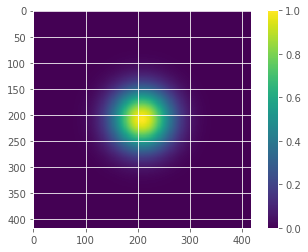

In [49]:
plt.imshow(makeGaussian(pixels(11), pixels(2.5)))
plt.colorbar()

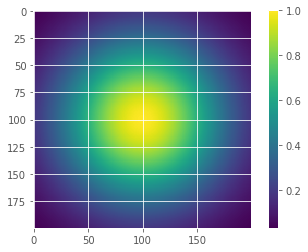

In [11]:
plt.imshow(makeGaussian(200, (7/11)*200))
plt.colorbar()

In [348]:
(screen_area(10) / pixel_size) / 800

0.4723044126119597

In [372]:
a = scipy.signal.convolve2d(list(human_heatmaps.values())[0], makeGaussian(200, (7/11)*200), mode='same')

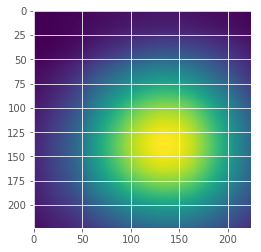

In [373]:
plt.imshow(a)

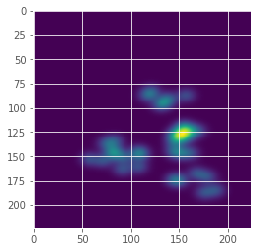

In [460]:
plt.imshow(list(human_heatmaps.values())[100])

In [451]:
image_max = scipy.ndimage.maximum_filter(list(human_heatmaps.values())[1], size=10, mode='constant')

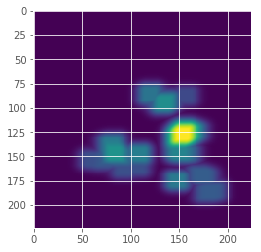

In [452]:
plt.imshow(image_max)